# 1. Environment Setup and Data Loading

This notebook replicates the methodological framework presented in the paper *"The Fog of War: Detecting Structural Regimes of Volatility in Long-Term Conflict Data"*.

First, we install the required statistical libraries:
*   `pmdarima`: For the automatic selection of SARIMA parameters.
*   `ruptures`: For the implementation of Change-Point Detection (CPD) algorithms (PELT and Binary Segmentation).

Then, we load the raw dataset of the Colombian Internal Armed Conflict (1958-2022). As detailed in the methodology, we apply a **Square-Root Transformation** ($Y'_t = \sqrt{Y_t}$) to the raw count of *Cases of Collective Violence*. This transformation is essential to stabilize the variance and mitigate the heteroskedasticity inherent in conflict data without artificially inflating the volatility of low-intensity periods.

In [ ]:
# --- 1.1 Install non-standard libraries ---
# We use %%capture to suppress the installation output log
%%capture
!pip install pmdarima ruptures

# --- 1.2 Import dependencies ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from google.colab import drive

# Configure plot aesthetics for the paper
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.family"] = "serif" # Serif font for a professional academic look

# --- 1.3 Load Data from Google Drive ---
drive.mount('/content/drive')

# Path to the dataset
file_path = '/content/drive/MyDrive/Series de tiempo_gaussian/monthlyViolenceColombia.xlsx'

# Load the Excel file
df = pd.read_excel(file_path)

# --- 1.4 Pre-processing ---
# Convert 'period' to datetime objects (Format YYYY/MM)
df['date'] = pd.to_datetime(df['period'], format='%Y/%m')

# Set the date as the index (crucial for Time Series analysis)
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Select the main variable for analysis
# We focus on "Cases of collective violence" as the primary indicator
target_variable = 'Cases of collective violence'

# Apply Square-Root Transformation (Equation 1 in the paper)
df['sqrt_cases'] = np.sqrt(df[target_variable])

print(f"Data successfully loaded. Time range: {df.index.min().strftime('%Y-%m')} to {df.index.max().strftime('%Y-%m')}")
print("Square-root transformation applied.")
print(df[[target_variable, 'sqrt_cases']].head())

# 1.5 Methodological Framework (Figure 1)

Before proceeding with the quantitative analysis, we visualize the dual-path framework proposed in this study. This diagram corresponds to **Figure 1** in the manuscript.

The pipeline consists of:
1.  **Input:** Raw time series of violence.
2.  **Pre-processing:** Square-root transformation to stabilize variance.
3.  **Path A (Intensity):** STL Decomposition + Binary Segmentation to identify strategic eras.
4.  **Path B (Uncertainty):** SARIMA Filtering + PELT Algorithm to identify volatility regimes.

<>:36: SyntaxWarning: invalid escape sequence '\e'
<>:36: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-1742790983.py:36: SyntaxWarning: invalid escape sequence '\e'
  c.node('D2', 'Residuals\n($\epsilon_t$)')


Flowchart generated: methodology_flow_landscape.png


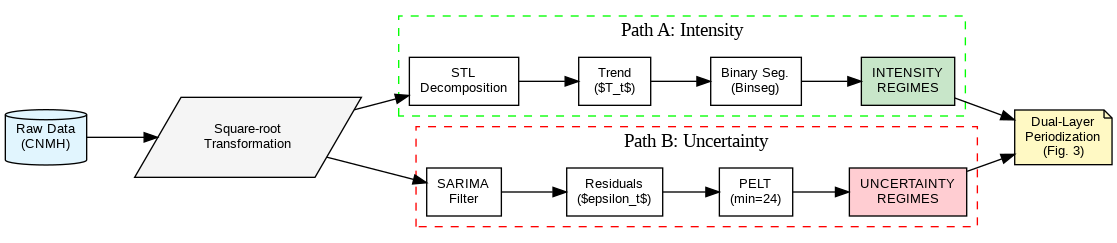

In [ ]:
# --- 0. Generate Methodological Flowchart (Landscape Version) ---
from graphviz import Digraph
from google.colab import files

# Create Digraph object
dot = Digraph(comment='Methodology', format='png')

# CHANGE HERE: 'LR' = Left-to-Right (Landscape)
dot.attr(rankdir='LR', size='12,5') # Adjusted size ratio for landscape

# Define Node Styles
dot.attr('node', shape='box', style='filled', fillcolor='white', fontname='Helvetica', fontsize='10')

# --- Nodes ---
# Input (Leftmost)
dot.node('A', 'Raw Data\n(CNMH)', shape='cylinder', fillcolor='#E1F5FE')

# Pre-processing
# CAMBIO REALIZADO AQUÍ: Texto limpio en lugar de LaTeX fallido
dot.node('B', 'Square-root\nTransformation', shape='parallelogram', fillcolor='#F5F5F5')

# Path A Branch (Top Stream)
with dot.subgraph(name='cluster_0') as c:
    c.attr(style='dashed', label='Path A: Intensity', color='green')
    c.node('C1', 'STL\nDecomposition')
    c.node('C2', 'Trend\n($T_t$)')
    c.node('C3', 'Binary Seg.\n(Binseg)')
    c.node('C4', 'INTENSITY\nREGIMES', style='filled', fillcolor='#C8E6C9')
    # Force horizontal alignment within cluster
    c.attr(rankdir='LR')

# Path B Branch (Bottom Stream)
with dot.subgraph(name='cluster_1') as c:
    c.attr(style='dashed', label='Path B: Uncertainty', color='red')
    c.node('D1', 'SARIMA\nFilter')
    c.node('D2', 'Residuals\n($\epsilon_t$)')
    c.node('D3', 'PELT\n(min=24)')
    c.node('D4', 'UNCERTAINTY\nREGIMES', style='filled', fillcolor='#FFCDD2')
    # Force horizontal alignment within cluster
    c.attr(rankdir='LR')

# Synthesis (Rightmost)
dot.node('E', 'Dual-Layer\nPeriodization\n(Fig. 3)', shape='note', fillcolor='#FFF9C4')

# --- Edges ---
dot.edge('A', 'B')

# Split
dot.edge('B', 'C1')
dot.edge('B', 'D1')

# Path A Flow
dot.edge('C1', 'C2')
dot.edge('C2', 'C3')
dot.edge('C3', 'C4')

# Path B Flow
dot.edge('D1', 'D2')
dot.edge('D2', 'D3')
dot.edge('D3', 'D4')

# Merge
dot.edge('C4', 'E')
dot.edge('D4', 'E')

# --- Render and View ---
filename = 'methodology_flow_landscape'
dot.render(filename, view=False)
print(f"Flowchart generated: {filename}.png")

# Display
from IPython.display import Image
display(Image(f'{filename}.png'))

# 2. Path A: Characterizing Intensity (Trend Analysis)

This section implements the first path of our methodological framework: characterizing the magnitude of violence over time.

**Methodology:**
1.  **STL Decomposition:** We use the *Seasonal-Trend decomposition using LOESS* (STL) to filter out high-frequency noise and seasonal patterns from the square-root transformed series. This yields a smooth **Trend Component** ($\hat{T}_t$) representing the underlying intensity of the conflict.
2.  **Binary Segmentation (Binseg):** To identify structural historical eras (e.g., Escalation, Peak, Stabilization), we apply the `Binseg` change-point detection algorithm on the extracted trend. Unlike optimization methods that find an arbitrary number of breaks, `Binseg` allows us to search for a specific number of structural breaks ($K$).
3.  **Parameters:** Consistent with Colombian historiography, we set `n_bkps=4` (generating 5 distinct regimes) and impose a minimum segment size of 36 months to capture long-term strategic phases.

**Output:**
A visualization of the Intensity Regimes (Green bands) overlaid on the trend, corresponding to **Panel A** of the paper's main figure.

--- Path A Results for: Cases of collective violence ---
Structural Breakpoints detected (Indices): [335, 460, 560, 600, 768]
Regime Change 1: 1985-12
Regime Change 2: 1996-05
Regime Change 3: 2004-09
Regime Change 4: 2008-01


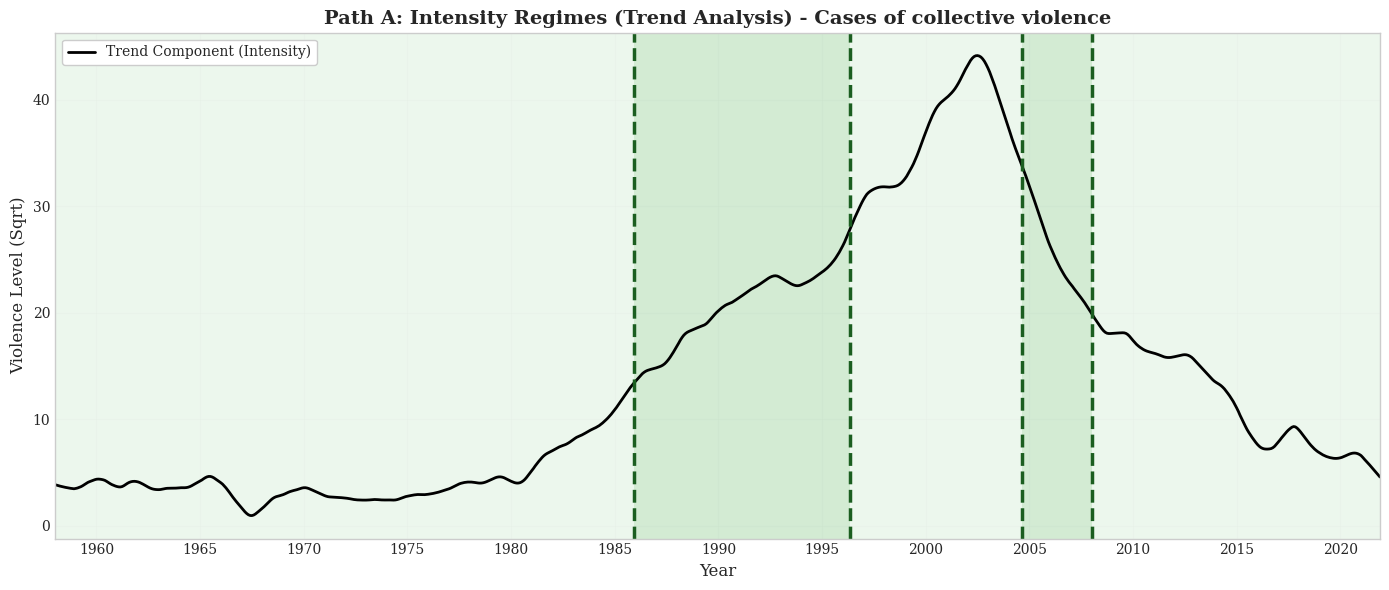

In [ ]:
from statsmodels.tsa.seasonal import STL
import ruptures as rpt

# --- 2.1 Configuration ---
# Select the column to analyze.
# Options: 'Cases of collective violence' (Aggregate), 'Cases of selective violence', 'Cases of indiscriminate violence'
TARGET_COLUMN = 'Cases of collective violence'

# Ensure we use the Square-Root transformed version of the selected column
# We calculate it on the fly to ensure consistency if the target column changes
series_transformed = np.sqrt(df[TARGET_COLUMN])

# --- 2.2 STL Decomposition ---
# robust=True: Reduces the influence of outliers on the trend estimate
# period=12: Monthly data
stl_res = STL(series_transformed, period=12, robust=True).fit()
trend_component = stl_res.trend.values

# --- 2.3 Change-Point Detection (Trend) ---
# Algorithm: Binary Segmentation (Binseg)
# Cost function: L2 (Least Squares), appropriate for detecting mean shifts
# min_size: 36 months (3 years) to focus on strategic eras
algo_trend = rpt.Binseg(model="l2", min_size=36).fit(trend_component)

# We search for exactly 4 breakpoints to define 5 historical regimes
trend_bkps = algo_trend.predict(n_bkps=4)

print(f"--- Path A Results for: {TARGET_COLUMN} ---")
print(f"Structural Breakpoints detected (Indices): {trend_bkps}")

# --- 2.4 Visualization (Panel A style) ---
fig, ax = plt.subplots(figsize=(14, 6))

# Plot the smooth Trend component
ax.plot(df.index, trend_component, color='black', linewidth=2, label='Trend Component (Intensity)')

# Define aesthetics for regimes (Green palette)
colors_trend = ["#E8F5E9", "#C8E6C9"] # Alternating light greens
start_idx = 0

# Loop through detected breakpoints to shade regimes
for i, end_idx in enumerate(trend_bkps):
    # Handle end of series index
    if end_idx >= len(df): end_idx = len(df) - 1

    # Define time range for the segment
    start_date = df.index[start_idx]
    end_date = df.index[end_idx]

    # Shade the regime area
    ax.axvspan(start_date, end_date, color=colors_trend[i % 2], alpha=0.8, lw=0)

    # Plot vertical divider (except for the last point which is end of series)
    if i < len(trend_bkps) - 1:
        ax.axvline(end_date, color='#1B5E20', linestyle='--', linewidth=2.5)

        # Print date for reference
        print(f"Regime Change {i+1}: {end_date.strftime('%Y-%m')}")

    start_idx = end_idx

# Final Plot formatting
ax.set_title(f'Path A: Intensity Regimes (Trend Analysis) - {TARGET_COLUMN}', fontsize=14, fontweight='bold')
ax.set_ylabel('Violence Level (Sqrt)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.legend(loc='upper left', frameon=True, framealpha=1)
ax.set_xlim(df.index[0], df.index[-1])
ax.grid(True, alpha=0.3)

# Format x-axis dates
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

# 3. Path B: Characterizing Uncertainty (Residual Analysis)

This section implements the second, and most novel, path of our framework: characterizing the **volatility** (unpredictability) of violence.

**Methodology:**
1.  **SARIMA Filtering:** To analyze the stochastic component, we must first remove all linear dependencies (trend and seasonality). We use `auto_arima` to fit an optimal **Seasonal Autoregressive Integrated Moving Average** (SARIMA) model to the square-root transformed series. The model parameters $(p,d,q)(P,D,Q)_{12}$ are selected via AIC minimization.
2.  **Residual Extraction:** We obtain the standardized residuals ($\hat{\epsilon}_t$) from the fitted model. These represent the "shocks" or the "fog of war."
3.  **PELT Algorithm:** We apply the *Pruned Exact Linear Time* (PELT) algorithm to the residuals. We use a **Radial Basis Function (RBF)** kernel cost function, which allows us to detect changes in the distribution's dispersion (variance) without assuming a specific parametric distribution.
4.  **Constraints:** We impose a minimum segment length of **24 months** (`min_size=24`) to filter out short-term tactical fluctuations and focus on structural strategic uncertainty.

**Output:**
A visualization of the "Volatility Tunnel" (Red bands) representing the changing standard deviation ($\sigma_t$) of the conflict over time.

--- Path B: Analyzing Uncertainty for Cases of collective violence ---
Fitting Auto-ARIMA model... (This may take a few seconds)
Optimal Model Found: (1, 1, 1)(1, 1, 1, 12)
Volatility Breakpoints detected (Indices): [35, 470, 535, 575, 768]
Volatility Change 1: 1960-12
Volatility Change 2: 1997-03
Volatility Change 3: 2002-08
Volatility Change 4: 2005-12


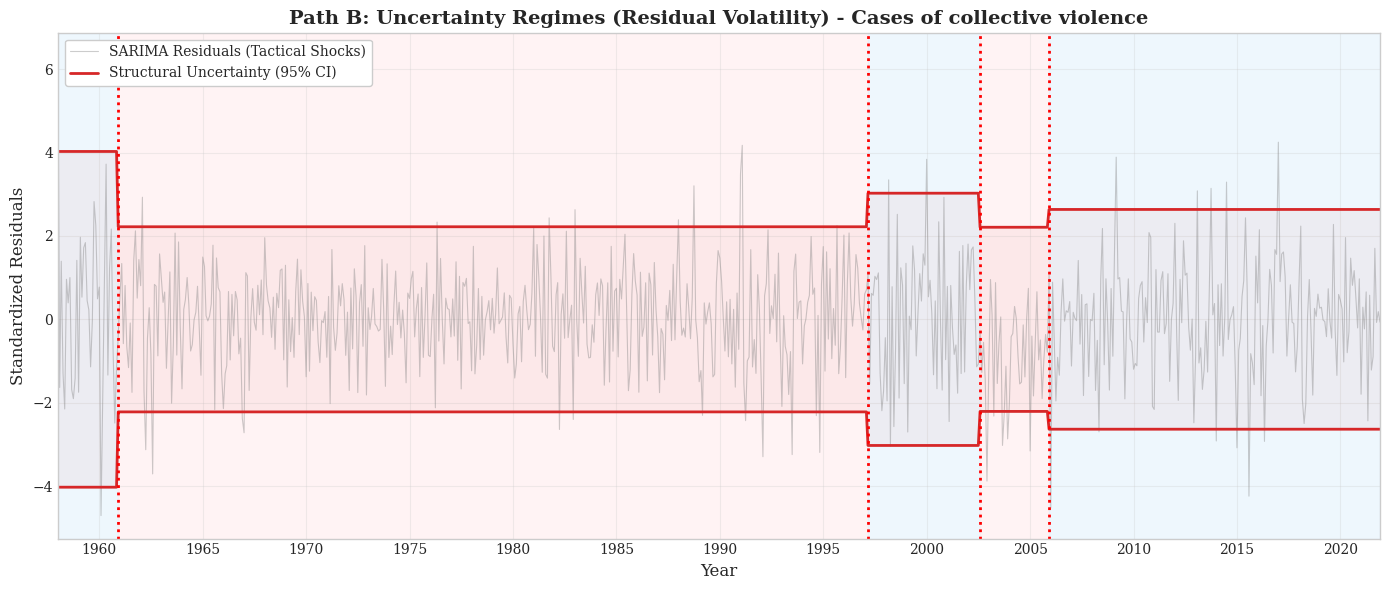


--- Estimated Volatility per Regime ---
     Start  Sigma (Std)
0  1958-01        2.054
1  1960-12        1.132
2  1997-03        1.543
3  2002-08        1.127
4  2005-12        1.344


In [ ]:
import pmdarima as pm

# --- 3.1 SARIMA Filtering ---
print(f"--- Path B: Analyzing Uncertainty for {TARGET_COLUMN} ---")
print("Fitting Auto-ARIMA model... (This may take a few seconds)")

# We use the same transformed series from Step 2
# Parameters:
# m=12: Monthly seasonality
# d=1, D=1: Force differencing to remove trend and seasonal levels
# seasonal=True: Enable seasonal components
model_sarima = pm.auto_arima(series_transformed,
                             start_p=0, start_q=0,
                             max_p=3, max_q=3,
                             m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1,
                             trace=False,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print(f"Optimal Model Found: {model_sarima.order}{model_sarima.seasonal_order}")

# Extract Residuals
residuals = model_sarima.resid()
# Convert to numpy array for ruptures
signal_residuals = residuals.values if hasattr(residuals, 'values') else residuals

# --- 3.2 Change-Point Detection (Volatility) ---
# Algorithm: PELT
# Cost function: RBF (Radial Basis Function) - Detects distribution changes
# min_size: 24 months (2 years)
algo_vol = rpt.Pelt(model="rbf", min_size=24).fit(signal_residuals)

# Predict breakpoints
# pen=2: Standard penalty for change detection
vol_bkps = algo_vol.predict(pen=2)

print(f"Volatility Breakpoints detected (Indices): {vol_bkps}")

# --- 3.3 Calculate Volatility Tunnel (Sigma) ---
# We calculate the Standard Deviation for each detected segment
volatility_curve = np.zeros(len(signal_residuals))
start_idx = 0
regime_stats = []

for end_idx in vol_bkps:
    if end_idx > len(signal_residuals): end_idx = len(signal_residuals)

    # Calculate std dev for this specific segment
    segment = signal_residuals[start_idx:end_idx]
    std_val = np.std(segment)
    volatility_curve[start_idx:end_idx] = std_val

    # Store stats for logging
    if start_idx < len(df):
        regime_stats.append({
            'Start': df.index[start_idx].strftime('%Y-%m'),
            'Sigma (Std)': round(std_val, 3)
        })

    start_idx = end_idx

# --- 3.4 Visualization (Panel B style) ---
fig, ax = plt.subplots(figsize=(14, 6))

# A. Plot Raw Residuals (The "Noise")
ax.plot(df.index, signal_residuals, color='gray', alpha=0.4, linewidth=0.8, label='SARIMA Residuals (Tactical Shocks)')

# B. Plot Volatility Tunnel (Structural Uncertainty)
# 1.96 * Std Dev approximates the 95% Confidence Interval
upper_bound = volatility_curve * 1.96
lower_bound = -volatility_curve * 1.96

ax.plot(df.index, upper_bound, color='#d62728', linewidth=2, label='Structural Uncertainty (95% CI)')
ax.plot(df.index, lower_bound, color='#d62728', linewidth=2)
# Fill the tunnel
ax.fill_between(df.index, lower_bound, upper_bound, color='#d62728', alpha=0.05)

# C. Background Coloring for Regimes
colors_vol = ["#e3f2fd", "#ffebee"] # Light Blue / Light Red alternating
start_idx = 0
for i, end_idx in enumerate(vol_bkps):
    if end_idx >= len(df): end_idx = len(df) - 1

    # Shade background
    ax.axvspan(df.index[start_idx], df.index[end_idx], color=colors_vol[i % 2], alpha=0.6, zorder=0)

    # Vertical divider
    if i < len(vol_bkps) - 1:
        ax.axvline(df.index[end_idx], color='red', linestyle=':', linewidth=2)
        print(f"Volatility Change {i+1}: {df.index[end_idx].strftime('%Y-%m')}")

    start_idx = end_idx

# Final Formatting
ax.set_title(f'Path B: Uncertainty Regimes (Residual Volatility) - {TARGET_COLUMN}', fontsize=14, fontweight='bold')
ax.set_ylabel('Standardized Residuals', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.legend(loc='upper left', frameon=True, framealpha=1)
ax.set_xlim(df.index[0], df.index[-1])
ax.grid(True, alpha=0.3)

ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

# Print regime statistics
print("\n--- Estimated Volatility per Regime ---")
print(pd.DataFrame(regime_stats))

# 3.1 Model Diagnostics (Figure 2)

Before proceeding to the final regime classification, we must validate the statistical assumptions of our SARIMA model. This step generates **Figure 2** of the manuscript.

We examine the residuals for:
1.  **Standardized Residuals:** Should show constant variance (homoscedasticity) after the square-root transformation.
2.  **Histogram / KDE:** Should approximate a Normal distribution $N(0,1)$.
3.  **Q-Q Plot:** Points should align with the red line, indicating normality.
4.  **Correlogram (ACF):** Should show no significant spikes outside the blue shaded region, indicating that the model has captured all temporal dependencies (Trend and Seasonality).

Generating SARIMA Diagnostics Plot...


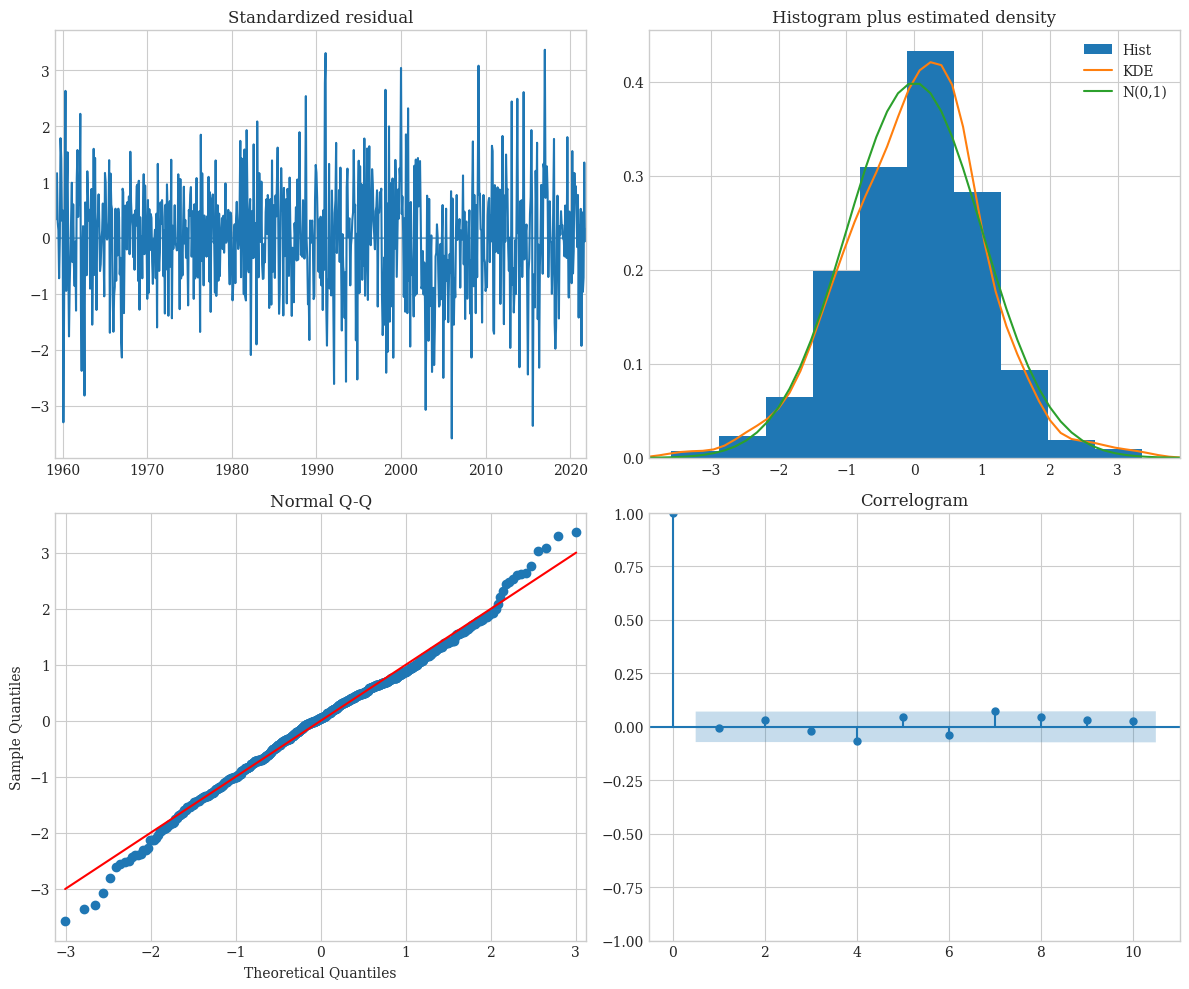

Figure saved as: sarima_diagnostics.png
Please download this file and upload it to Overleaf as Figure 2.


In [ ]:
# --- 3.1 Generate Figure 2: SARIMA Diagnostics ---
# This plot confirms the assumptions of normality and lack of autocorrelation
# required for the residual analysis.

print("Generating SARIMA Diagnostics Plot...")

# Generate the 4-panel diagnostic plot
# figsize=(12, 10) ensures high resolution for the paper
fig = model_sarima.plot_diagnostics(figsize=(12, 10))

# Customize layout
plt.tight_layout()

# Save the figure to file
filename = 'sarima_diagnostics.png'
plt.savefig(filename, dpi=300)
plt.show()

print(f"Figure saved as: {filename}")
print("Please download this file and upload it to Overleaf as Figure 2.")

# 4. Generation of Figure 3: Combined Conflict Regimes

This step synthesizes the results from Path A and Path B into the final publication figure.

We utilize `matplotlib.subplots` with `sharex=True` to ensure perfect temporal alignment between the two dimensions.
*   **Panel A:** Displays the **Intensity** (Trend) calculated in Step 2, overlaid with the regimes detected by Binary Segmentation.
*   **Panel B:** Displays the **Uncertainty** (Volatility) calculated in Step 3, showing the "Volatility Tunnel" and regimes detected by PELT.

This visual comparison allows us to identify the decoupling of magnitude and volatility, particularly around the 2002-2003 transition.

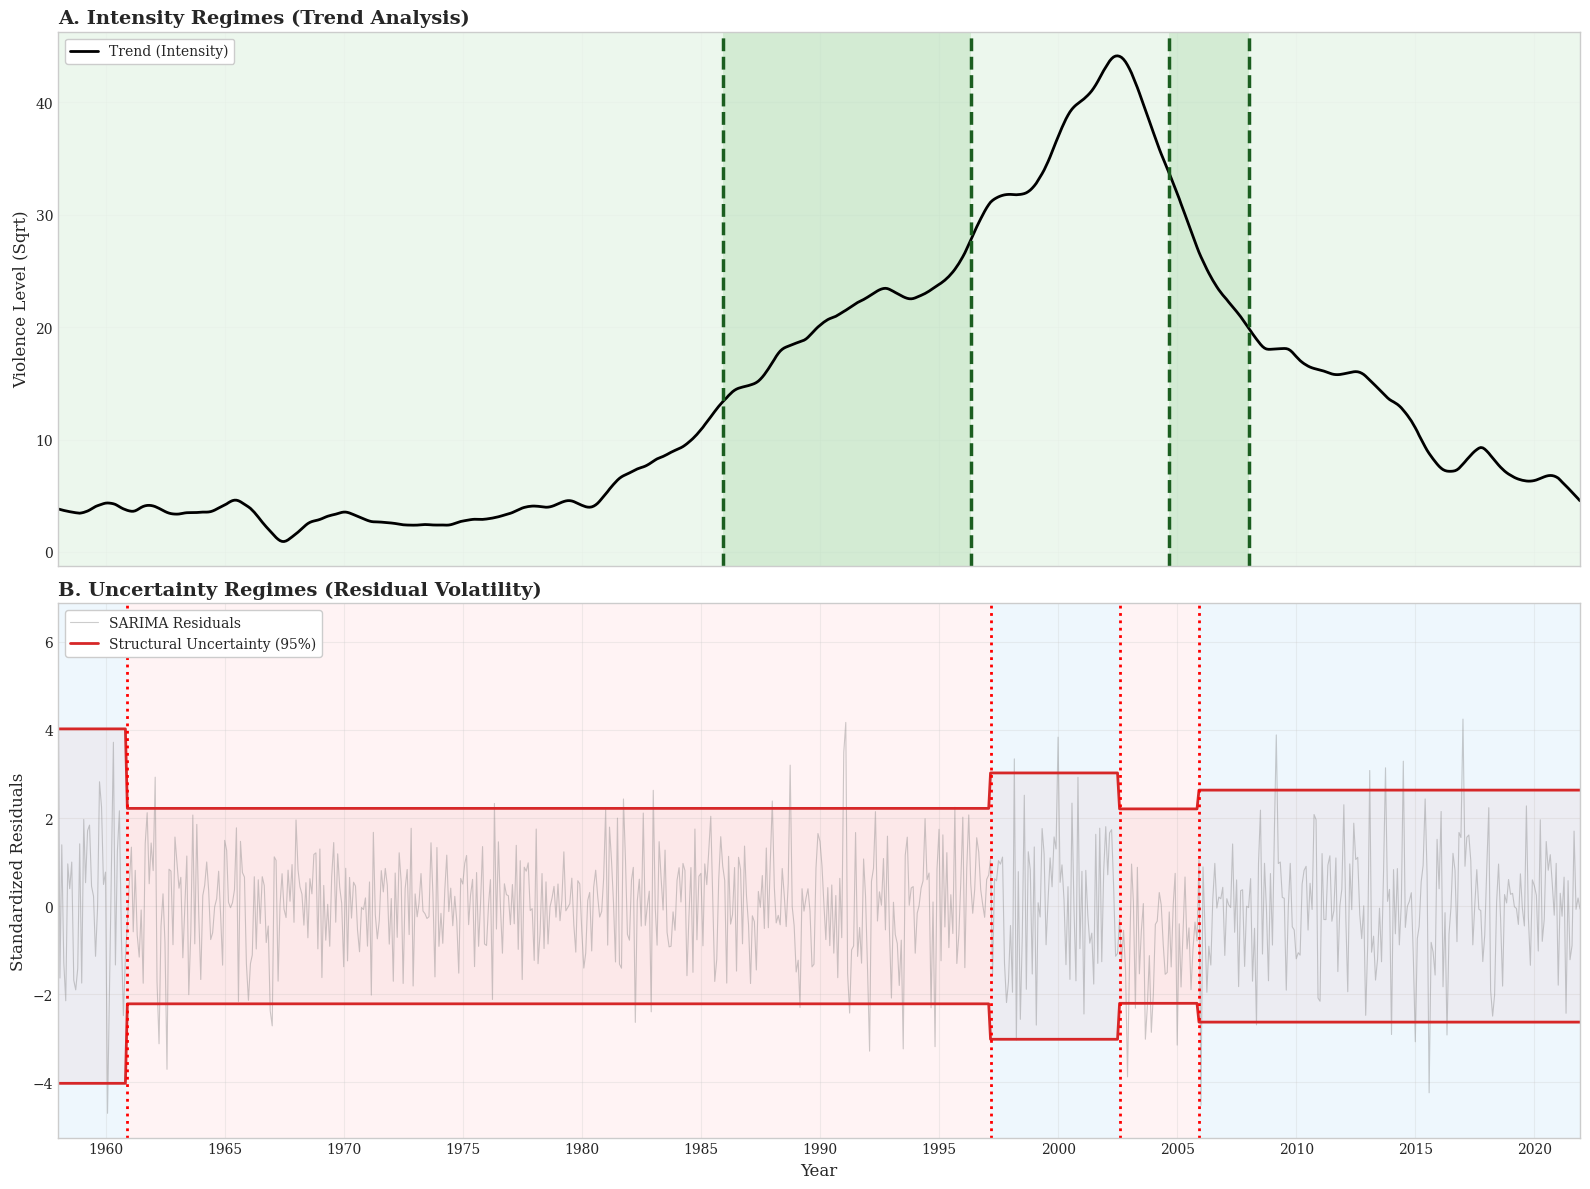

Figure 3 saved as: combined_regimes.png


In [ ]:
# --- 4. Generation of Figure 3 (Combined Regimes) ---

# Create a figure with two vertical subplots sharing the X-axis
fig, ax = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# =========================================================
# PANEL A: INTENSITY REGIMES (From Path A)
# =========================================================
# Plot the Trend Component calculated in Step 2
ax[0].plot(df.index, trend_component, color='black', linewidth=2, label='Trend (Intensity)')

# Define Intensity Colors (Greens)
colors_trend = ["#E8F5E9", "#C8E6C9"]
start_idx = 0

# Loop through Trend Breakpoints (calculated in Step 2)
for i, end_idx in enumerate(trend_bkps):
    if end_idx >= len(df): end_idx = len(df) - 1

    # Shade the regime
    ax[0].axvspan(df.index[start_idx], df.index[end_idx], color=colors_trend[i % 2], alpha=0.8, lw=0)

    # Vertical Divider (Green Dashed)
    if i < len(trend_bkps) - 1:
        ax[0].axvline(df.index[end_idx], color='#1B5E20', linestyle='--', linewidth=2.5)

    start_idx = end_idx

# Aesthetics for Panel A
ax[0].set_title('A. Intensity Regimes (Trend Analysis)', fontsize=14, fontweight='bold', loc='left')
ax[0].set_ylabel('Violence Level (Sqrt)', fontsize=12)
ax[0].legend(loc='upper left', frameon=True, framealpha=1)
ax[0].grid(True, alpha=0.3)

# =========================================================
# PANEL B: UNCERTAINTY REGIMES (From Path B)
# =========================================================
# Plot the Raw Residuals calculated in Step 3
ax[1].plot(df.index, signal_residuals, color='gray', alpha=0.4, linewidth=0.8, label='SARIMA Residuals')

# Plot the Volatility Tunnel (95% CI) calculated in Step 3
upper_bound = volatility_curve * 1.96
lower_bound = -volatility_curve * 1.96
ax[1].plot(df.index, upper_bound, color='#d62728', linewidth=2, label='Structural Uncertainty (95%)')
ax[1].plot(df.index, lower_bound, color='#d62728', linewidth=2)
ax[1].fill_between(df.index, lower_bound, upper_bound, color='#d62728', alpha=0.05)

# Define Volatility Colors (Blue/Red)
colors_vol = ["#e3f2fd", "#ffebee"]
start_idx = 0

# Loop through Volatility Breakpoints (calculated in Step 3)
for i, end_idx in enumerate(vol_bkps):
    if end_idx >= len(df): end_idx = len(df) - 1

    # Shade the regime
    ax[1].axvspan(df.index[start_idx], df.index[end_idx], color=colors_vol[i % 2], alpha=0.6, lw=0, zorder=0)

    # Vertical Divider (Red Dotted)
    if i < len(vol_bkps) - 1:
        ax[1].axvline(df.index[end_idx], color='red', linestyle=':', linewidth=2)

    start_idx = end_idx

# Aesthetics for Panel B
ax[1].set_title('B. Uncertainty Regimes (Residual Volatility)', fontsize=14, fontweight='bold', loc='left')
ax[1].set_ylabel('Standardized Residuals', fontsize=12)
ax[1].set_xlabel('Year', fontsize=12)
ax[1].legend(loc='upper left', frameon=True, framealpha=1)
ax[1].grid(True, alpha=0.3)

# =========================================================
# GLOBAL ADJUSTMENTS & SAVING
# =========================================================
# Set X-axis limits to match data range exactly
ax[1].set_xlim(df.index[0], df.index[-1])

# Format X-axis dates (Every 5 years)
ax[1].xaxis.set_major_locator(mdates.YearLocator(5))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()

# Save the figure for Overleaf
filename_fig3 = 'combined_regimes.png'
plt.savefig(filename_fig3, dpi=300)
plt.show()

print(f"Figure 3 saved as: {filename_fig3}")

# 5. Comparative Analysis: Heterogeneity of Violence Types

Finally, we extend the analysis to specific modalities of violence to assess the robustness of our findings. The paper argues that different forms of violence may obey different strategic logics. Therefore, we replicate the "Path B" (Residual Volatility) analysis for disaggregated indicators: **Cases of Selective Violence** and **Cases of Indiscriminate Violence**.

**Methodology:**
1.  We iterate through the target columns.
2.  For each series, we apply the Square-Root transformation.
3.  We fit a specific SARIMA model to isolate its unique residuals.
4.  We run the PELT algorithm (`min_size=24`) to detect its specific volatility regimes.

**Output:**
A comparative "Timeline Plot" showing the structural breakpoints for each violence type. This visualization helps identify if the degradation of the conflict was simultaneous across dimensions or if certain types of violence became unpredictable at different times.

--- Starting Comparative Analysis ---
Processing: Cases of collective violence...
  -> Detected 4 structural breaks.
Processing: Cases of selective violence...
  -> Detected 5 structural breaks.
Processing: Cases of indiscriminate violence...
  -> Detected 3 structural breaks.
Analysis Complete.


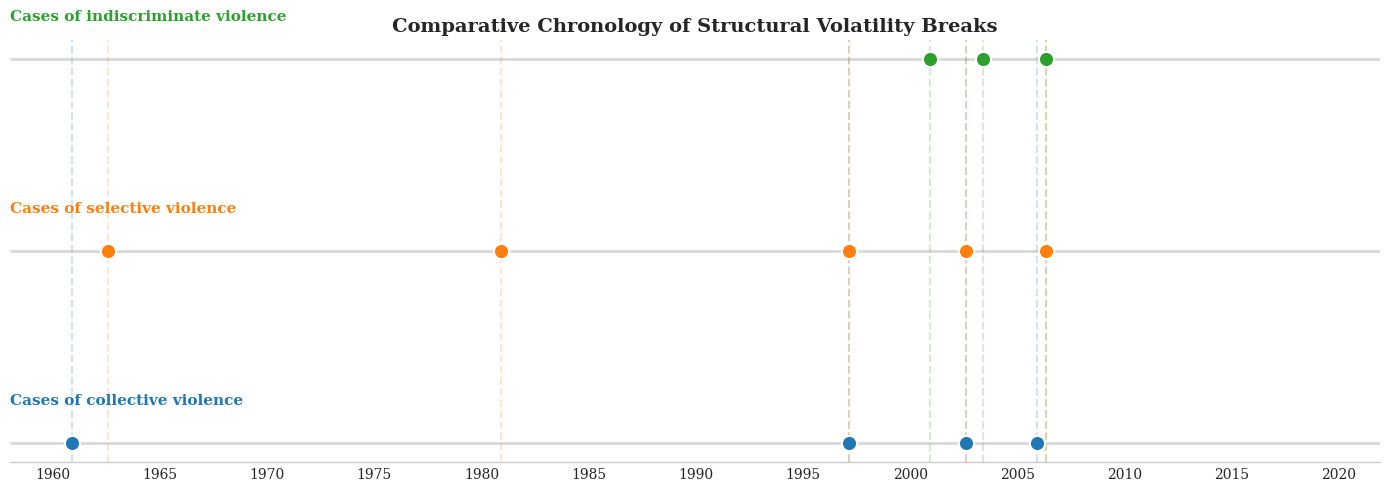

In [ ]:
# --- 5.1 Configuration ---
# List of columns to compare
comparison_columns = [
    'Cases of collective violence',
    'Cases of selective violence',
    'Cases of indiscriminate violence'
]

# Dictionary to store results
comparative_results = {}
colors_map = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green

print("--- Starting Comparative Analysis ---")

# --- 5.2 Analysis Loop ---
for col in comparison_columns:
    print(f"Processing: {col}...")

    # A. Transform
    # Apply Square Root (Equation 1)
    series_comp = np.sqrt(df[col])

    # B. SARIMA Filtering
    # We use Auto-ARIMA to find the best filter for THIS specific series
    model_comp = pm.auto_arima(series_comp, start_p=0, start_q=0, max_p=2, max_q=2, m=12,
                               seasonal=True, d=1, D=1, trace=False,
                               error_action='ignore', suppress_warnings=True)

    resid_comp = model_comp.resid()
    signal_comp = resid_comp.values if hasattr(resid_comp, 'values') else resid_comp

    # C. PELT Detection (Volatility)
    # Maintain consistency with the main analysis (min_size=24)
    algo_comp = rpt.Pelt(model="rbf", min_size=24).fit(signal_comp)
    bkps_comp = algo_comp.predict(pen=2)

    # Convert indices to Dates
    dates_comp = []
    for cp in bkps_comp[:-1]: # Ignore the last point (end of series)
        if cp < len(df):
            dates_comp.append(df.index[cp])

    comparative_results[col] = dates_comp
    print(f"  -> Detected {len(dates_comp)} structural breaks.")

print("Analysis Complete.")

# --- 5.3 Visualization (Timeline Plot) ---
fig, ax = plt.subplots(figsize=(14, 5))

# Plot timeline for each variable
for i, (name, dates) in enumerate(comparative_results.items()):
    y_pos = i * 2

    # Draw timeline base
    ax.hlines(y_pos, df.index[0], df.index[-1], color='gray', alpha=0.3, linewidth=2)

    # Draw breakpoints
    ax.scatter(dates, [y_pos]*len(dates), s=120, c=colors_map[i], label=name, zorder=3, edgecolors='white', linewidth=1.5)

    # Draw phantom vertical lines for comparison
    for date in dates:
        ax.axvline(date, color=colors_map[i], alpha=0.2, linestyle='--')

    # Label
    ax.text(df.index[0], y_pos + 0.4, name, fontsize=11, fontweight='bold', color=colors_map[i])

# Formatting
ax.set_yticks([]) # Hide y-axis
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_title('Comparative Chronology of Structural Volatility Breaks', fontsize=14, fontweight='bold')
ax.set_xlim(df.index[0], df.index[-1])
ax.grid(False) # Clean look
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

# Appendix: Instructions for Replicating Disaggregated Analysis

The analysis presented above focuses on the aggregate indicator: **"Cases of collective violence"**. However, the repository supports the replication of the entire pipeline for disaggregated modalities (Selective vs. Indiscriminate Violence) or for Victim counts.

To generate **Figure 2 (Diagnostics)** and **Figure 3 (Combined Regimes)** for a different variable, follow these steps:

1.  Navigate to **Step 2 (Path A)** code cell.
2.  Locate the configuration line:
    ```python
    TARGET_COLUMN = 'Cases of collective violence'
    ```
3.  Change the variable name to one of the following available columns:
    *   `'Cases of selective violence'`
    *   `'Cases of indiscriminate violence'`
    *   `'Victims of collective violence'` (Note: Victim counts are noisier and may require adjusting parameters).
4.  **Re-run all subsequent cells** (Step 2 through Step 4).

The notebook will automatically re-calculate the transformations, re-fit the Auto-ARIMA model, and generate new plots specific to the selected modality. The **Comparative Analysis (Step 5)** runs independently and already includes a loop over all case-based variables.